In [65]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


In [66]:
# load ratings and movie metadata
ratings_cols = ["user_id","item_id","rating","timestamp"]
ratings = pd.read_csv("ml-100k/u.data", sep="\t", names=ratings_cols, engine="python")
items_cols = ["item_id","title","release_date","video_release_date","imdb_url","unknown","Action","Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama","Fantasy","Film-Noir","Horror","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western"]
items = pd.read_csv("ml-100k/u.item", sep="|", names=items_cols, encoding="latin-1")
ratings = ratings.merge(items[["item_id","title"]], on="item_id", how="left")
print(ratings.head())
print(ratings.shape)


   user_id  item_id  rating  timestamp                       title
0      196      242       3  881250949                Kolya (1996)
1      186      302       3  891717742    L.A. Confidential (1997)
2       22      377       1  878887116         Heavyweights (1994)
3      244       51       2  880606923  Legends of the Fall (1994)
4      166      346       1  886397596         Jackie Brown (1997)
(100000, 5)


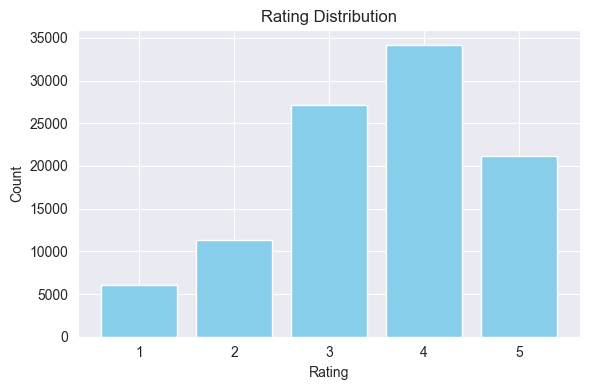

rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: count, dtype: int64


In [67]:
# basic exploration of rating distribution
rating_counts = ratings['rating'].value_counts().sort_index()
plt.figure(figsize=(6,4))
plt.bar(rating_counts.index.astype(str), rating_counts.values, color="skyblue")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Rating Distribution")
plt.tight_layout()
plt.show()
print(rating_counts)


In [68]:
# build user item rating matrix
user_item_matrix = ratings.pivot_table(index='user_id', columns='item_id', values='rating', aggfunc='mean')
user_item_filled = user_item_matrix.fillna(0.0)
print(user_item_filled.shape)


(943, 1682)


In [69]:
# compute user user cosine similarity matrix
user_vectors = user_item_filled.values
similarity_matrix = cosine_similarity(user_vectors)
np.fill_diagonal(similarity_matrix, 0.0)
sim_df = pd.DataFrame(similarity_matrix, index=user_item_filled.index, columns=user_item_filled.index)
print(sim_df.iloc[:5, :5])


user_id         1         2         3         4         5
user_id                                                  
1        0.000000  0.166931  0.047460  0.064358  0.378475
2        0.166931  0.000000  0.110591  0.178121  0.072979
3        0.047460  0.110591  0.000000  0.344151  0.021245
4        0.064358  0.178121  0.344151  0.000000  0.031804
5        0.378475  0.072979  0.021245  0.031804  0.000000


In [70]:
# function to generate top n recommendations for a user based on weighted ratings from similar users
def recommend_for_user(target_user_id, top_n=10, min_sim=0.0):
    if target_user_id not in user_item_filled.index:
        return []
    user_index_map = {u: i for i, u in enumerate(user_item_filled.index)}
    idx = user_index_map[target_user_id]
    sims = similarity_matrix[idx]
    rated_mask = user_item_filled.loc[target_user_id] > 0
    unseen_items = user_item_filled.columns[~rated_mask]
    if len(unseen_items) == 0:
        return []
    sims_filtered = np.where(sims >= min_sim, sims, 0)
    if sims_filtered.sum() == 0:
        return []
    others_ratings = user_item_filled.loc[:, unseen_items].values
    weighted_scores = sims_filtered @ others_ratings / (np.abs(sims_filtered).sum() + 1e-8)
    recs = pd.DataFrame({"item_id": unseen_items, "score": weighted_scores})
    recs = recs.sort_values("score", ascending=False).head(top_n)
    recs = recs.merge(items[["item_id","title"]], on="item_id", how="left")
    return recs

example_recs = recommend_for_user(1, top_n=10)
print(example_recs)


   item_id     score                                   title
0      318  2.044246                 Schindler's List (1993)
1      423  1.879326       E.T. the Extra-Terrestrial (1982)
2      357  1.799883  One Flew Over the Cuckoo's Nest (1975)
3      286  1.749977             English Patient, The (1996)
4      288  1.703413                           Scream (1996)
5      483  1.697157                       Casablanca (1942)
6      405  1.601258              Mission: Impossible (1996)
7      294  1.583601                        Liar Liar (1997)
8      496  1.530334            It's a Wonderful Life (1946)
9      655  1.473604                      Stand by Me (1986)


In [71]:
# simple demonstration of recommendations for a few users
for uid in [1, 50, 100]:
    print("User", uid)
    print(recommend_for_user(uid, top_n=5))
    print()


User 1
   item_id     score                                   title
0      318  2.044246                 Schindler's List (1993)
1      423  1.879326       E.T. the Extra-Terrestrial (1982)
2      357  1.799883  One Flew Over the Cuckoo's Nest (1975)
3      286  1.749977             English Patient, The (1996)
4      288  1.703413                           Scream (1996)

User 50
   item_id     score                      title
0       50  2.553504           Star Wars (1977)
1      258  2.248342             Contact (1997)
2      127  2.023277      Godfather, The (1972)
3      181  1.994444  Return of the Jedi (1983)
4        7  1.890237      Twelve Monkeys (1995)

User 100
   item_id     score                      title
0       50  1.856534           Star Wars (1977)
1      100  1.611768               Fargo (1996)
2      181  1.481284  Return of the Jedi (1983)
3      748  1.455711          Saint, The (1997)
4      127  1.310257      Godfather, The (1972)



In [72]:
# prepare train test split per user for evaluation
rng = np.random.default_rng(42)
ratings_sorted = ratings.sort_values(['user_id','timestamp'])
train_list = []
test_list = []
for uid, grp in ratings_sorted.groupby('user_id'):
    if len(grp) <= 5:
        train_list.append(grp)
        continue
    test_size = max(1, int(0.2 * len(grp)))
    test_idx = rng.choice(grp.index, size=test_size, replace=False)
    test_grp = grp.loc[test_idx]
    train_grp = grp.drop(test_idx)
    train_list.append(train_grp)
    test_list.append(test_grp)
train_ratings = pd.concat(train_list).reset_index(drop=True)
test_ratings = pd.concat(test_list).reset_index(drop=True)
print(train_ratings.shape, test_ratings.shape)


(80367, 5) (19633, 5)


In [73]:
# rebuild matrices on train data only
train_user_item = train_ratings.pivot_table(index='user_id', columns='item_id', values='rating', aggfunc='mean')
train_user_item_filled = train_user_item.fillna(0.0)
train_vectors = train_user_item_filled.values
train_similarity = cosine_similarity(train_vectors)
np.fill_diagonal(train_similarity, 0.0)
train_sim_df = pd.DataFrame(train_similarity, index=train_user_item_filled.index, columns=train_user_item_filled.index)
print(train_sim_df.shape)


(943, 943)


In [74]:
# recommendation function using train artifacts for evaluation
user_index_map_eval = {u: i for i, u in enumerate(train_user_item_filled.index)}

def recommend_eval(user_id, top_k=10, min_sim=0.0):
    if user_id not in train_user_item_filled.index:
        return []
    idx = user_index_map_eval[user_id]
    sims = train_similarity[idx]
    rated_mask = train_user_item_filled.loc[user_id] > 0
    unseen_items = train_user_item_filled.columns[~rated_mask]
    if len(unseen_items) == 0:
        return []
    sims_filtered = np.where(sims >= min_sim, sims, 0)
    if sims_filtered.sum() == 0:
        return []
    others_ratings = train_user_item_filled.loc[:, unseen_items].values
    weighted_scores = sims_filtered @ others_ratings / (np.abs(sims_filtered).sum() + 1e-8)
    recs = pd.DataFrame({"item_id": unseen_items, "score": weighted_scores})
    recs = recs.sort_values("score", ascending=False).head(top_k)
    return recs['item_id'].tolist()

print(recommend_eval(1, top_k=5)[:5])


[50, 318, 423, 191, 357]


In [75]:
# compute precision at k across users
def precision_at_k(k=5, threshold=4):
    user_relevant = test_ratings[test_ratings['rating'] >= threshold].groupby('user_id')['item_id'].apply(set)
    users = train_user_item_filled.index
    precisions = []
    for u in users:
        recs = recommend_eval(u, top_k=k)
        if len(recs) == 0:
            continue
        rel = user_relevant.get(u, set())
        if len(rel) == 0:
            continue
        hit_count = sum(1 for r in recs if r in rel)
        precisions.append(hit_count / k)
    if len(precisions) == 0:
        return 0.0
    return float(np.mean(precisions))

for k in [3,5,10]:
    print("Precision@", k, ":", precision_at_k(k))


Precision@ 3 : 0.27843559382848937
Precision@ 5 : 0.2378902045209903
Precision@ 10 : 0.1953713670613563


In [76]:
# show sample recommended movie titles after evaluation
print(recommend_for_user(1, top_n=10))


   item_id     score                                   title
0      318  2.044246                 Schindler's List (1993)
1      423  1.879326       E.T. the Extra-Terrestrial (1982)
2      357  1.799883  One Flew Over the Cuckoo's Nest (1975)
3      286  1.749977             English Patient, The (1996)
4      288  1.703413                           Scream (1996)
5      483  1.697157                       Casablanca (1942)
6      405  1.601258              Mission: Impossible (1996)
7      294  1.583601                        Liar Liar (1997)
8      496  1.530334            It's a Wonderful Life (1946)
9      655  1.473604                      Stand by Me (1986)


In [77]:
# compute popularity baseline precision at k
popularity_order = train_ratings.groupby('item_id')['rating'].mean().sort_values(ascending=False).index.tolist()
train_user_items_sets = {u: set(train_ratings[train_ratings.user_id==u].item_id) for u in train_ratings.user_id.unique()}

def popularity_precision_at_k(k=5, threshold=4):
    user_relevant = test_ratings[test_ratings['rating'] >= threshold].groupby('user_id')['item_id'].apply(set)
    precisions = []
    for u in train_user_item_filled.index:
        rel = user_relevant.get(u, set())
        if len(rel) == 0:
            continue
        rated = train_user_items_sets.get(u, set())
        recs = [it for it in popularity_order if it not in rated][:k]
        if len(recs) == 0:
            continue
        hit_count = sum(1 for r in recs if r in rel)
        precisions.append(hit_count / k)
    if len(precisions) == 0:
        return 0.0
    return float(np.mean(precisions))

for k in [3,5,10]:
    print("Popularity Precision@", k, ":", popularity_precision_at_k(k))


Popularity Precision@ 3 : 0.0
Popularity Precision@ 5 : 0.0
Popularity Precision@ 10 : 0.0


In [78]:
# diagnostics for zero popularity precision
threshold = 4
user_relevant = test_ratings[test_ratings['rating'] >= threshold].groupby('user_id')['item_id'].apply(set)
eligible_users = [u for u in train_user_item_filled.index if len(user_relevant.get(u, set())) > 0]
print('Eligible users with at least one relevant test item:', len(eligible_users))
for k in [3,5,10]:
    hit_users = 0
    total_hits = 0
    for u in eligible_users:
        rel = user_relevant.get(u, set())
        rated = train_user_items_sets.get(u, set())
        recs = [it for it in popularity_order if it not in rated][:k]
        hits = sum(1 for r in recs if r in rel)
        if hits > 0:
            hit_users += 1
        total_hits += hits
    print(f'K={k} users_with_hit={hit_users} total_hits={total_hits}')

sample_users = eligible_users[:5]
print('Sample user details:')
for u in sample_users:
    rel = user_relevant.get(u, set())
    rated = train_user_items_sets.get(u, set())
    recs5 = [it for it in popularity_order if it not in rated][:5]
    print({'user': u, 'relevant_test_items': list(rel)[:8], 'recs5': recs5})


Eligible users with at least one relevant test item: 929
K=3 users_with_hit=0 total_hits=0
K=5 users_with_hit=0 total_hits=0
K=10 users_with_hit=0 total_hits=0
Sample user details:
{'user': 1, 'relevant_test_items': [129, 257, 267, 15, 154, 43, 46, 47], 'recs5': [1653, 1656, 1122, 1293, 1536]}
{'user': 2, 'relevant_test_items': [1, 251, 25, 303], 'recs5': [1653, 1656, 1122, 1293, 1536]}
{'user': 3, 'relevant_test_items': [260], 'recs5': [1653, 1656, 1122, 1293, 1536]}
{'user': 4, 'relevant_test_items': [288, 329, 50, 294], 'recs5': [1653, 1656, 1122, 1293, 1536]}
{'user': 5, 'relevant_test_items': [385, 228, 390, 169, 173, 430, 208, 209], 'recs5': [1653, 1656, 1122, 1293, 1536]}


In [79]:
# improved popularity baseline with minimum rating count filter
item_stats = train_ratings.groupby('item_id')['rating'].agg(['mean','count'])
min_count = 20
filtered_items = item_stats[item_stats['count'] >= min_count].sort_values('mean', ascending=False).index.tolist()

def popularity_min_count_precision_at_k(k=5, threshold=4):
    user_relevant_local = test_ratings[test_ratings['rating'] >= threshold].groupby('user_id')['item_id'].apply(set)
    precisions = []
    for u in train_user_item_filled.index:
        rel = user_relevant_local.get(u, set())
        if len(rel) == 0:
            continue
        rated = train_user_items_sets.get(u, set())
        recs = [it for it in filtered_items if it not in rated][:k]
        if len(recs) == 0:
            continue
        hit_count = sum(1 for r in recs if r in rel)
        precisions.append(hit_count / k)
    if len(precisions) == 0:
        return 0.0
    return float(np.mean(precisions))

for k in [3,5,10]:
    print('Popularity (min_count) Precision@', k, ':', popularity_min_count_precision_at_k(k))


Popularity (min_count) Precision@ 3 : 0.06602081090778615
Popularity (min_count) Precision@ 5 : 0.06372443487621099
Popularity (min_count) Precision@ 10 : 0.06501614639397202


In [80]:
# popularity baseline using rating frequency (most rated items) precision
most_rated_order = item_stats.sort_values('count', ascending=False).index.tolist()

def popularity_frequency_precision_at_k(k=5, threshold=4):
    user_relevant_local = test_ratings[test_ratings['rating'] >= threshold].groupby('user_id')['item_id'].apply(set)
    precisions = []
    for u in train_user_item_filled.index:
        rel = user_relevant_local.get(u, set())
        if len(rel) == 0:
            continue
        rated = train_user_items_sets.get(u, set())
        recs = [it for it in most_rated_order if it not in rated][:k]
        if len(recs) == 0:
            continue
        hit_count = sum(1 for r in recs if r in rel)
        precisions.append(hit_count / k)
    if len(precisions) == 0:
        return 0.0
    return float(np.mean(precisions))

for k in [3,5,10]:
    print('Popularity (frequency) Precision@', k, ':', popularity_frequency_precision_at_k(k))


Popularity (frequency) Precision@ 3 : 0.16325798349479725
Popularity (frequency) Precision@ 5 : 0.15069967707212056
Popularity (frequency) Precision@ 10 : 0.13433799784714748


In [81]:
# build item similarity matrix from train data
item_user_matrix = train_user_item_filled.T  # items x users
item_vectors = item_user_matrix.values
item_similarity = cosine_similarity(item_vectors)
np.fill_diagonal(item_similarity, 0.0)
item_sim_df = pd.DataFrame(item_similarity, index=item_user_matrix.index, columns=item_user_matrix.index)
print(item_sim_df.shape)
print(item_sim_df.iloc[:5, :5])


(1648, 1648)
item_id         1         2         3         4         5
item_id                                                  
1        0.000000  0.310323  0.276136  0.361735  0.261923
2        0.310323  0.000000  0.237137  0.400206  0.227974
3        0.276136  0.237137  0.000000  0.298860  0.182153
4        0.361735  0.400206  0.298860  0.000000  0.282819
5        0.261923  0.227974  0.182153  0.282819  0.000000


In [82]:
# item based recommendation function
def recommend_item_based(user_id, top_k=10, top_n_neighbors=50, min_sim=0.0):
    if user_id not in train_user_item_filled.index:
        return []
    user_ratings = train_user_item.loc[user_id]
    rated_items = user_ratings[user_ratings.notna()].index.tolist()
    if len(rated_items) == 0:
        return []
    all_items = train_user_item_filled.columns
    unseen = [it for it in all_items if it not in rated_items]
    if not unseen:
        return []
    scores = []
    rated_idx_map = {it: i for i, it in enumerate(item_user_matrix.index)}
    for it in unseen:
        if it not in item_sim_df.index:
            continue
        sims = item_sim_df.loc[it, rated_items]
        sims_filtered = sims[sims >= min_sim]
        if sims_filtered.empty:
            continue
        top_sims = sims_filtered.sort_values(ascending=False).head(top_n_neighbors)
        rated_vals = user_ratings.loc[top_sims.index].fillna(0.0)
        denom = np.abs(top_sims.values).sum()
        if denom == 0:
            continue
        score = (top_sims.values * rated_vals.values).sum() / denom
        scores.append((it, score))
    if len(scores) == 0:
        return []
    recs = pd.DataFrame(scores, columns=['item_id','score']).sort_values('score', ascending=False).head(top_k)
    recs = recs.merge(items[['item_id','title']], on='item_id', how='left')
    return recs

print(recommend_item_based(1, top_k=5))


   item_id     score                                           title
0      297  4.445723                              Ulee's Gold (1997)
1     1149  4.405682                                Walkabout (1971)
2     1068  4.400039  Star Maker, The (Uomo delle stelle, L') (1995)
3      919  4.399153               City of Lost Children, The (1995)
4     1241  4.391196                                 Van, The (1996)


In [83]:
# precision evaluation for item based collaborative filtering
def item_precision_at_k(k=5, threshold=4):
    user_relevant_local = test_ratings[test_ratings['rating'] >= threshold].groupby('user_id')['item_id'].apply(set)
    precisions = []
    for u in train_user_item_filled.index:
        rec_df = recommend_item_based(u, top_k=k)
        if isinstance(rec_df, list) or len(rec_df) == 0:
            continue
        recs = rec_df['item_id'].tolist()
        rel = user_relevant_local.get(u, set())
        if len(rel) == 0:
            continue
        hit_count = sum(1 for r in recs if r in rel)
        precisions.append(hit_count / k)
    if len(precisions) == 0:
        return 0.0
    return float(np.mean(precisions))

for k in [3,5,10]:
    print('ItemCF Precision@', k, ':', item_precision_at_k(k))


ItemCF Precision@ 3 : 0.023322569070685324
ItemCF Precision@ 5 : 0.02691065662002153
ItemCF Precision@ 10 : 0.02852529601722282


In [84]:
# matrix factorization via truncated svd on train user item matrix
rank = 50
M = train_user_item_filled.values  # users x items
U, S, Vt = np.linalg.svd(M, full_matrices=False)
U_k = U[:, :rank]
S_k = S[:rank]
Vt_k = Vt[:rank, :]
reconstructed = (U_k * S_k) @ Vt_k
svd_pred_df = pd.DataFrame(reconstructed, index=train_user_item_filled.index, columns=train_user_item_filled.columns)
print(svd_pred_df.shape)


(943, 1648)


In [85]:
# svd based recommendation function
def recommend_svd(user_id, top_k=10):
    if user_id not in svd_pred_df.index:
        return []
    user_row_pred = svd_pred_df.loc[user_id]
    rated_mask = train_user_item_filled.loc[user_id] > 0
    unseen_scores = user_row_pred[~rated_mask]
    if unseen_scores.empty:
        return []
    recs = unseen_scores.sort_values(ascending=False).head(top_k).reset_index()
    recs.columns = ['item_id','score']
    recs = recs.merge(items[['item_id','title']], on='item_id', how='left')
    return recs

print(recommend_svd(1, top_k=5))


   item_id     score                                              title
0      433  3.722587                                    Heathers (1989)
1      408  3.097554                              Close Shave, A (1995)
2      508  2.931363                 People vs. Larry Flynt, The (1996)
3      462  2.708822  Like Water For Chocolate (Como agua para choco...
4      684  2.455960                         In the Line of Fire (1993)


In [86]:
# precision evaluation for svd recommender
def svd_precision_at_k(k=5, threshold=4):
    user_relevant_local = test_ratings[test_ratings['rating'] >= threshold].groupby('user_id')['item_id'].apply(set)
    precisions = []
    for u in train_user_item_filled.index:
        rec_df = recommend_svd(u, top_k=k)
        if isinstance(rec_df, list) or len(rec_df) == 0:
            continue
        recs = rec_df['item_id'].tolist()
        rel = user_relevant_local.get(u, set())
        if len(rel) == 0:
            continue
        hit_count = sum(1 for r in recs if r in rel)
        precisions.append(hit_count / k)
    if len(precisions) == 0:
        return 0.0
    return float(np.mean(precisions))

for k in [3,5,10]:
    print('SVD Precision@', k, ':', svd_precision_at_k(k))


SVD Precision@ 3 : 0.30893433799784714
SVD Precision@ 5 : 0.27491926803013994
SVD Precision@ 10 : 0.22055974165769646


In [87]:
# summary comparison across methods
for k in [5,10]:
    user_cf = precision_at_k(k)
    item_cf = item_precision_at_k(k)
    svd_cf = svd_precision_at_k(k)
    pop_mean = popularity_precision_at_k(k)
    pop_freq = popularity_frequency_precision_at_k(k)
    print(f'K={k} UserCF={user_cf:.4f} ItemCF={item_cf:.4f} SVD={svd_cf:.4f} PopMean={pop_mean:.4f} PopFreq={pop_freq:.4f}')



K=5 UserCF=0.2379 ItemCF=0.0269 SVD=0.2749 PopMean=0.0000 PopFreq=0.1507
K=10 UserCF=0.1954 ItemCF=0.0285 SVD=0.2206 PopMean=0.0000 PopFreq=0.1343
